## Table of Content
1. [Load Data](#Load-Data)
2. [Feature Extraction](#Feature-Extraction)
3. [TimeSeriesSplit](#TimeSeriesSplit)
4. [Transform to Supervised Setup](#transform-to-supervised-setup)
5. [Train LSTM-based autoencoder](#train-lstm-based-autoencoder)
6. [Train Linear Model](#train-linear-model)
7. [Feedback Needed](#feedback-needed)
8. [Appendix: Data Preparation](#appendix-data-preparation)

## Project Goal

The goal of this project is to predict 20-day return of stock `AAPL`. While modern advances in transformers are promising for time-series forecasting, recent works show that MLPs and linear models have comparable capabilities in some tasks. Inspired by such work, we implement an ensemble of linear models with different lookback period to predict 20-day return of stock `AAPL`. We first obtain the raw data of quotes, financials, and fundamentals from yahoo finance. Then, we unify and preprocess the data format into a single `DataFrame`(see [Appendix](#appendix-data-preparation) for more details). With an unified data, we extract features of technical indicators from the data, split into train-val-test sets, standardize them, and then transform into a supervised setup. To denoise the data, we perform dimensionality reduction through training an autoencoder. Finally, we train multiple MLPs on the reduced data to perform forecasting.

## Load Data

The data loaded here has been combined and unified from multiple raw data sources. The dates are restricted to 2013/05/06 - 2023/04/26.

In [1]:
import pandas as pd
data = pd.read_csv('../prepared_data/data.csv')
data.columns

Index(['Unnamed: 0', 'Date', 'Open', 'Close', 'High', 'Low', 'Volume',
       'S&P500', 'PeRatio', 'PsRatio', 'PbRatio',
       'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio',
       'BasicEPS'],
      dtype='object')

## Feature Extraction

The goal is to get these technical indicators. Most of them are implemented using an open-source library [`stock_indicators`](https://python.stockindicators.dev/).

- $n$-day return
- Typical Price = average of high, low, and close
- [Relative Strength Index](https://en.wikipedia.org/wiki/Relative_strength_index)
- [Stochastic Oscillator](https://en.wikipedia.org/wiki/Stochastic_oscillator)
- [Williams %R](https://www.investopedia.com/terms/w/williamsr.asp)
- [Moving Average Convergence Divergence(MACD)](https://www.investopedia.com/terms/m/macd.asp#:~:text=Moving%20average%20convergence%2Fdivergence%20(MACD%2C%20or%20MAC%2DD,from%20the%2012%2Dperiod%20EMA.)) = Short lookback EMA - Long lookback EMA
- [On-Balance Volume (OBV)](https://www.investopedia.com/terms/o/onbalancevolume.asp): Volume-based momentum
- [Commodity Channel Index (CCI)](https://www.investopedia.com/terms/c/commoditychannelindex.asp#:~:text=The%20Commodity%20Channel%20Index%20(CCI)%20is%20a%20technical%20indicator%20that,is%20below%20the%20historic%20average.): Evaluate the current price as opposed to the historical price
- $n$ days Moving Average
    - Simple Moving Average
    - Smoothed Moving Average
    - Exponential Moving Average
- [Average True Range (ATR)](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr#:~:text=Average%20True%20Range%20(ATR)%20is,daily%2C%20weekly%2C%20or%20monthly.): The average of the true range as a way to evaluate the volatility

Some technical indicators require previous $n$ days average of return or prices. We use `n` to represents the number of days we use for the averaging. By default, `n = 40`.

In [3]:
import numpy as np
from stock_indicators import Quote, indicators
from datetime import datetime

def data_to_quotes(data): 
    # Transform the date dtype to be compatible with stock_indicators pkg
    data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
    # A list of Quotes for using stock_indicators
    aapl = [
        Quote(d,o,h,l,c,v) 
        for d,o,h,l,c,v 
        in zip(data['Date'], data['Open'], data['High'], data['Low'], data['Close'], data['Volume'])
    ]
    return aapl

def n_day_return(X, n): 
    '''
    n-day return is (current day closing price - n days ago opening price) / n days ago opening price. 
    
    Args: 
        X (np.ndarray): 
            np.ndarray with open, close 
        n (int): 
            The number of days ago. 
        
    Returns: 
        n_day_return (np.array): 
            An array of n-day return with shape (len(X),) where the first n entries would be none
    '''
    op = np.array(X.Open[:-n])
    cls = np.array(X.Close[n:])
    ret = (cls - op) / (op)
    res =  np.concatenate(([None for i in range(n)], ret), axis=0)
    return res.reshape((-1, 1))
    
def typical_price(X): 
    '''
    Typical price is the average of close, high, and low prices. 
    
    Args:
        X (np.ndarray): 
            np.ndarray with close, high, low columns. 
        
    Returns: 
        typical_price (np.array): 
            An array of typical price
    '''
    return (X.high + X.low + X.close) / 3

def relative_strength_index(quotes, n): 
    rsi_results = indicators.get_rsi(quotes, n) 
    rsi = []
    for rsi_result in rsi_results: 
        rsi.append(rsi_result.rsi)
    return np.array(rsi).reshape((-1, 1)) 

def stochastic_oscillator(quotes, n): 
    stoch_results = indicators.get_stoch(quotes, lookback_periods=n)
    stoch = [] 
    for stoch_result in stoch_results: 
        stoch.append(stoch_result.oscillator) 
    return np.array(stoch).reshape((-1, 1)) 

def william_r(quotes, n): 
    william_r_results = indicators.get_williams_r(quotes, lookback_periods=n)
    william_r = [] 
    for william_r_result in william_r_results: 
        william_r.append(william_r_result.williams_r)
    return np.array(william_r).reshape((-1, 1)) 

def macd(quotes, short_period, long_period): 
    macd_results = indicators.get_macd(quotes, fast_periods=short_period, slow_periods=long_period)
    macd = [] 
    for macd_result in macd_results: 
        macd.append(macd_result.macd) 
    return np.array(macd).reshape((-1, 1)) 

def on_balanced_volume(quotes, n): 
    obv_results = indicators.get_obv(quotes, sma_periods=n) 
    obv = []
    for obv_result in obv_results: 
        obv.append(obv_result.obv)
    return np.array(obv).reshape((-1, 1))

def commodity_channel_index(quotes, n): 
    cci_results = indicators.get_cci(quotes, lookback_periods=n)
    cci = []
    for cci_result in cci_results: 
        cci.append(cci_result.cci) 
    return np.array(cci).reshape((-1, 1)) 

def simple_moving_average(quotes, n): 
    sma_results = indicators.get_sma(quotes, n) 
    sma = []
    for sma_result in sma_results: 
        sma.append(sma_result.sma) 
    return np.array(sma).reshape((-1, 1))  

def smoothed_moving_average(quotes, n): 
    smma_results = indicators.get_smma(quotes, n) 
    smma = []
    for smma_result in smma_results: 
        smma.append(smma_result.smma)
    return np.array(smma).reshape((-1, 1))  

def exponential_moving_average(quotes, n): 
    ema_results = indicators.get_ema(quotes, n) 
    ema = []
    for ema_result in ema_results: 
        ema.append(ema_result.ema) 
    return np.array(ema).reshape((-1, 1)) 

def average_true_range(quotes, n): 
    atr_results = indicators.get_atr(quotes, n) 
    atr = [] 
    for atr_result in atr_results: 
        atr.append(atr_result.atr) 
    return np.array(atr).reshape((-1, 1)) 

We use a column transformer to concatenate all extracted features

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# n refers to the number of days to lookback for some of the features 
#   e.g. william %R would take into account the highest high price in a given period. That period is determined by n 
n = 40
# short_period and long_period are for MACD 
short_period = n // 2 
long_period = n

# Concatenate the columns
transformer = ColumnTransformer([
    ('original_features', 'passthrough', data.columns),
    ('rsi', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('rsi', FunctionTransformer(relative_strength_index, kw_args={'n': n}))
    ]), data.columns),
    ('stoch', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('stoch', FunctionTransformer(stochastic_oscillator, kw_args={'n': n}))
    ]), data.columns),
    ('william_r', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('william_r', FunctionTransformer(william_r, kw_args={'n': n}))
    ]), data.columns),
    ('macd', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('macd', FunctionTransformer(macd, kw_args={'short_period': short_period, 'long_period': long_period}))
    ]), data.columns),
    ('obv', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('obv', FunctionTransformer(on_balanced_volume, kw_args={'n': n}))
    ]), data.columns),
    ('cci', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('cci', FunctionTransformer(commodity_channel_index, kw_args={'n': n}))
    ]), data.columns),
    ('sma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('sma', FunctionTransformer(simple_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('smma', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('smma', FunctionTransformer(smoothed_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('ema', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('ema', FunctionTransformer(exponential_moving_average, kw_args={'n': n}))
    ]), data.columns),
    ('atr', Pipeline([
        ('to_quotes', FunctionTransformer(data_to_quotes)), 
        ('atr', FunctionTransformer(average_true_range, kw_args={'n': n}))
    ]), data.columns),
    ('5_day_return', FunctionTransformer(n_day_return, kw_args={'n': 5}), ['Open', 'Close']), 
    ('10_day_return', FunctionTransformer(n_day_return, kw_args={'n': 10}), ['Open', 'Close']), 
    ('n_day_return', FunctionTransformer(n_day_return, kw_args={'n': n}), ['Open', 'Close']),
    ('20_day_return', FunctionTransformer(n_day_return, kw_args={'n': 20}), ['Open', 'Close']), 
], remainder='passthrough')

# Drop the first and the second column which is indices and dates
full_data = transformer.fit_transform(data)[:, 1:]

Since some of the technical indicators require lookback, the first $n$ points would contain `None`. We choose to drop those data points.

In [5]:
prefix = 0 
while prefix < full_data.shape[0]: 
    if np.equal(full_data[prefix:], None).any():
        prefix += 1
    else: 
        break
full_data = full_data[prefix:]
print(full_data.shape)

(2471, 27)


## TimeSeriesSplit

We use [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit.split) to split the data into 3-fold to train and evaluate the model. In addition, `test set` is split into `validation set` and `test set` to tune the model. 

In [6]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=3, max_train_size=900) 
folds = []
for i, (train_index, test_index) in enumerate(tscv.split(full_data)):
     # First 90 dates of test set
     validation_index = test_index[:90]
     test_index = test_index[90:]
     print(f"Fold {i}:")
     print(f"  Training set size = {len(train_index)}")
     print(f"  Validation set size = {len(validation_index)}")
     print(f"  Test set size = {len(test_index)}")
     print(f"  Training set start date = {full_data[train_index[0], 0]}")
     print(f"  Training set end date = {full_data[train_index[-1], 0]}")
     print(f"  Validation set start date = {full_data[validation_index[0], 0]}")
     print(f"  Validation set end date = {full_data[validation_index[-1], 0]}")
     print(f"  Test set start date = {full_data[test_index[0], 0]}")
     print(f"  Test set end date = {full_data[test_index[-1], 0]}")
     folds.append((train_index, validation_index, test_index))

Fold 0:
  Training set size = 620
  Validation set size = 90
  Test set size = 527
  Training set start date = 2013-07-03
  Training set end date = 2015-12-16
  Validation set start date = 2015-12-17
  Validation set end date = 2016-04-27
  Test set start date = 2016-04-28
  Test set end date = 2018-05-31
Fold 1:
  Training set size = 900
  Validation set size = 90
  Test set size = 527
  Training set start date = 2014-11-03
  Training set end date = 2018-05-31
  Validation set start date = 2018-06-01
  Validation set end date = 2018-10-08
  Test set start date = 2018-10-09
  Test set end date = 2020-11-10
Fold 2:
  Training set size = 900
  Validation set size = 90
  Test set size = 527
  Training set start date = 2017-04-18
  Training set end date = 2020-11-10
  Validation set start date = 2020-11-11
  Validation set end date = 2021-03-23
  Test set start date = 2021-03-24
  Test set end date = 2023-04-26


## Transform to Supervised Setup

A supervised setup consists of `X`, `y` where `X` are `L` days lookback of all the features and `y` is 20-day return. In addition, to satisfy the shape requirement of using LSTM-based autoencoder, we need to shape the data to be $n \times \text{timestep} \times \text{d}$, which is `n * L * d`. We store all `X_train, y_train, X_val, y_val, X_test, y_test` of each fold into a `list` of `dict` called `fold_data`.

In [7]:
from sklearn.preprocessing import StandardScaler

def supervised_transformer(data, L=10, H=1): 
    X, y = data 
    X_result = []
    y_result = []
    for i in range(L, X.shape[0]-H+1): 
        X_result.append(X[i-L:i])
        y_result.append(y[i:i+H])
    
    X_result = np.array(X_result)
    y_result = np.array(y_result).squeeze()
    print(f'X\'s shape = {X_result.shape}')
    print(f'y\'s shape = {y_result.shape}')
    return X_result, y_result

In [9]:
L = 5
fold_data = []

for (train_index, validation_index, test_index) in folds: 
    X_train = full_data[train_index, 1:]
    y_train = full_data[train_index, -1]
    X_val = full_data[validation_index, 1:]
    y_val = full_data[validation_index, -1]
    X_test = full_data[test_index, 1:]
    y_test = full_data[test_index, -1]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    X_train, y_train = supervised_transformer((X_train, y_train), L)
    X_val, y_val = supervised_transformer((X_val, y_val), L)
    X_test, y_test = supervised_transformer((X_test, y_test), L)
    fold_data.append({
        'X_train': X_train, 
        'y_train': y_train,
        'X_val': X_val, 
        'y_val': y_val, 
        'X_test': X_test, 
        'y_test': y_test
    })

X's shape = (615, 5, 26)
y's shape = (615,)
X's shape = (85, 5, 26)
y's shape = (85,)
X's shape = (522, 5, 26)
y's shape = (522,)
X's shape = (895, 5, 26)
y's shape = (895,)
X's shape = (85, 5, 26)
y's shape = (85,)
X's shape = (522, 5, 26)
y's shape = (522,)
X's shape = (895, 5, 26)
y's shape = (895,)
X's shape = (85, 5, 26)
y's shape = (85,)
X's shape = (522, 5, 26)
y's shape = (522,)


## Dimensionality reduction with LSTM-based autoencoder

Financial time series data is generally more noisy than typical dataset. There are a number of denoising technique such as Principle Component Analysis(PCA), Exponential Smoothing, and other dimensionality reduction methods. Here we adopt LSTM-based autoencoder because LSTM captures the lookback property of the data we are dealing with and we do need some sort of long term memory as a way to encode previous days features. The idea of autoencoder is a neural network composed of two parts: Encoder and Decoder. Encoder takes a high dimensional input space and compress it through some layers into a lower dimensional hidden layer. Decoder reverses the process by taking the lower dimensional hidden layer reduced by Encoder and decompress it through some layers mirroring the dimension of the Encoder and restore the original input. This way, when the neural network forward passes to the lower dimensional space at the end of the Encoder, it does the dimensionality reduction and denoises the input data. The Decoder can be viewed as reconstructing the input through the lower dimension representation of the input. Training the autoencoder can be interpreted as dimensionality reduction that reaches the lowest reconstruction error. The following implementation is inspired [here](https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352)

### `AutoEncoder`, `Encoder`, and `Decoder`

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf

def build_model(hp):  
    # TODO: hp.Fixed("L", value=5) outside
    h1 = hp.Int("h1", min_value=64, max_value=128, step=16, default=64)
    h2 = hp.Int("h2", min_value=10, max_value=30, step=4, default=15)
    l2_alpha = hp.Float("l2 alpha", min_value=0.0001, max_value=1.0, sampling="log")
    L = hp.Choice("L", values=[10, 20])
    lr = hp.Float("learning-rate", min_value=1e-6, max_value=1e-2, sampling="log")
    decay_rate = hp.Choice("decay-rate", values=[0.9, 0.8])
    args = {
        "h1": h1, 
        "h2": h2, 
        "l2 alpha": l2_alpha, 
        "L": L, 
        "learning-rate": lr, 
        "decay-rate": decay_rate
    }
    return build_model_param(args)

def build_model_param(args):  
    # TODO: hp.Fixed("L", value=5) outside
    h1 = args["h1"]
    h2 = args["h2"]
    l2_alpha = args["l2 alpha"]
    L = args["L"]
    lr = args["learning-rate"]
    decay_rate = args["decay-rate"]
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=10000,
        decay_rate=decay_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    encoder = Sequential([
        LSTM(h1, activation='relu', input_shape=(L, 26), return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha)), 
        LSTM(h2, activation='relu', return_sequences=False)
    ])
    decoder = Sequential([
        LSTM(h2, activation='relu', return_sequences=True), 
        LSTM(h1, activation='relu', return_sequences=True, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha)), 
        TimeDistributed(Dense(26, kernel_regularizer=tf.keras.regularizers.L2(l2_alpha)))
    ])
    auto_encoder = Sequential([
        encoder, 
        RepeatVector(L), 
        decoder
    ])
    auto_encoder.compile(optimizer=optimizer, loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    print("Model built...")
    return auto_encoder

### Spec 

1. `loss_fn`: **mean squared error**
2. `metrics`: **root mean squared error**
    - The reason for choosing `rmse` as the metrics is that it does not penalize outliers as much as `mse` which prevents from fitting too much to the outliers.
3. `optimizer`: **`Adam`**
4. Hyperparameter space 
    - `h1`: Dimension of the first hidden layer of encoder
    - `h2`: Dimension of the second hidden layer of encoder 
    - `lr`: Learning rate 
    - `l2 alpha`: Alpha for `l2` regularization
    - `decay rate`: decay rate for exponential learining rate scheduling
    - `L`: lookback period (number of days)
3. Model summary (see below)
    - AUTOENCODER summary contains three layers 
        1. Encoder which is summarized further below
        2. `RepeatVector` that repeats the output of the encoder because by exactly `L` times 
        3. Decoder which is summarized further below
    - ENCODER summary contains two layers 
        1. `LSTM(h1)`
        2. `LSTM(h2)`
    - DECODER summary contains three layers 
        1. `LSTM(h2)`
        2. `LSTM(h1)`
        3. `TimeDistributed` to distribute to timesteps for reconstruction

In [138]:
model = build_model_param({
    "h1": 128, 
    "h2": 64, 
    "learning-rate": 0.001, 
    "l2 alpha": 0.02, 
    "decay-rate": 1e-5, 
    "L": 5
})
print("=====AUTOENCODER SUMMARY=====")
print(model.summary())
print("=====ENCODER SUMMARY=====")
print(model.layers[0].summary())
print("=====DECODER SUMMARY=====")
print(model.layers[2].summary())

Model built...
=====AUTOENCODER SUMMARY=====
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64)                128768    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 5, 64)             0         
 tor)                                                            
                                                                 
 sequential_4 (Sequential)   (None, 5, 26)             135194    
                                                                 
Total params: 263962 (1.01 MB)
Trainable params: 263962 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
=====ENCODER SUMMARY=====
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape           

### Hyperparameter Search

The hyperparameters involved include the hidden layer sizes `h1, h2`, learning-rate, `alpha` for `L2 regularization`. Here we use `GridSearch` to look for a good set of configuration.

In [143]:
X_train, X_val, X_test = fold_data[0]["X_train"], fold_data[0]["X_val"], fold_data[0]["X_test"] 

In [144]:
import keras_tuner 

hp = keras_tuner.HyperParameters()

hp.Fixed("L", 5)

tuner = keras_tuner.GridSearch(
    build_model, 
    hyperparameters=hp, 
    objective=keras_tuner.Objective(name="val_rmse", direction="min"), 
    max_trials=20, 
    overwrite=True,
    directory="tmp/tb"
)

tuner.search(X_train, X_train, epochs=60, validation_data=(X_val, X_val), callbacks=[tf.keras.callbacks.TensorBoard("tmp/tb_logs")])

Trial 20 Complete [00h 00m 10s]
val_rmse: 1.0219486951828003

Best val_rmse So Far: 0.7706052660942078
Total elapsed time: 00h 03m 12s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


### Visualize hyperparameter search with `tensorboard`

In [76]:
# See tensorboard for hyperparameters visualization
!tensorboard --logdir tmp/tb_logs --port 6071

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6071/ (Press CTRL+C to quit)
^C


### Learning Curve

Model built...
Epoch 1/60
20/20 [==============================] - 2s 20ms/step - loss: 0.8786 - rmse: 0.9327 - val_loss: 1.3852 - val_rmse: 1.1736
Epoch 2/60
20/20 [==============================] - 0s 5ms/step - loss: 0.5893 - rmse: 0.7622 - val_loss: 1.2430 - val_rmse: 1.1109
Epoch 3/60
20/20 [==============================] - 0s 5ms/step - loss: 0.4156 - rmse: 0.6376 - val_loss: 1.1819 - val_rmse: 1.0828
Epoch 4/60
20/20 [==============================] - 0s 5ms/step - loss: 0.2964 - rmse: 0.5354 - val_loss: 1.0259 - val_rmse: 1.0080
Epoch 5/60
20/20 [==============================] - 0s 6ms/step - loss: 0.2478 - rmse: 0.4875 - val_loss: 1.1548 - val_rmse: 1.0699
Epoch 6/60
20/20 [==============================] - 0s 6ms/step - loss: 0.2216 - rmse: 0.4597 - val_loss: 1.1238 - val_rmse: 1.0552
Epoch 7/60
20/20 [==============================] - 0s 5ms/step - loss: 0.2066 - rmse: 0.4431 - val_loss: 1.1339 - val_rmse: 1.0600
Epoch 8/60
20/20 [==============================] - 0s 6ms/s

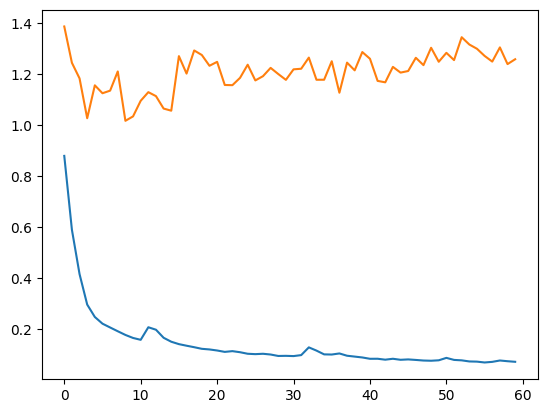

In [145]:
import matplotlib.pyplot as plt 
# Retrain the best model to get history
args = tuner.get_best_hyperparameters()[0]
model = build_model_param(args)
run = model.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=60)
train_history = run.history["loss"]
val_history = run.history["val_loss"]
# Plot the learning curve
plt.plot(train_history, label='train loss')
plt.plot(val_history, label='validation loss')
print(args.values)

### Comparison with `PCA`

We compare this dimensionality reduction with a typical dimensionality reduction approach `PCA` based on the reconstruction error in terms of `rmse` on validation set.

In [146]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
# Build PCA 
h2 = args["h2"]
pca = PCA(n_components=h2)
pca.fit(X_train.reshape((X_train.shape[0], -1)))
X_val_pca_red = pca.transform(X_val.reshape((X_val.shape[0], -1)))
print(X_val_pca_red.shape)
X_val_pca_rec = pca.inverse_transform(X_val_pca_red)
print(X_val_pca_rec.shape)
print(f"RMSE of reconstruction error with PCA reduction = {mean_squared_error(X_val_pca_rec, X_val.reshape(X_val.shape[0], -1), squared=False)}")
# Build autoencoder
model = tuner.get_best_models()[0]
X_val_auto_rec = model.predict(X_val).reshape((X_val.shape[0], -1))
print(X_val_auto_rec.shape)
print(f"RMSE of reconstruction error with autoencoder reduction = {mean_squared_error(X_val_auto_rec, X_val.reshape(X_val.shape[0], -1), squared=False)}")

(85, 15)
(85, 130)
RMSE of reconstruction error with PCA reduction = 0.27300160290981107


Model built...
3/3 [==============================] - 0s 2ms/step
(85, 130)
RMSE of reconstruction error with autoencoder reduction = 0.6777414230480353


We notice that `PCA` achieve better reconstruction error with the same dimensionality as our best `AutoEncoder`, so we adopt both and further compare them in the subsequent prediction performance.

### Additional Processing for normalization idea from `NLinear`

The idea of `NLinear` is a single linear layer with an additional step to "normalize" the prediction. Given an input, we first subtract all target variable in the lookback period ($y_t, y_{t+1}, ..., y_{t+L-1}$ in $X$ where $L$ is the number of days in the lookback period) by the most recent target variable ($y_{t+L-1}$) in the lookback period. In our case, we'll be subtracting the all `20-day return` in the feature space by the most recent `20-day return` in the lookback period. Then, we add the most recent target variable ($y_{t+L-1}$) back to the prediction $\hat{y}$. However, since we perform feature extraction through `AutoEncoder` in the previous step, we append the feature of `20-day return` explicitly back to the feature space after extraction.

In [ ]:
# Feature extraction for all folds 
def feature_processing(X, model): 
    '''
    Reduce dimensionality by using the model's encoder and append 20d return in the lookback period back to the reduced feature
    space

    Args: 
        X - np.ndarray with shape (n, L, d)
    ''' 
    lookback_20d_ret = X[:, :, -1]
    X_reduced = model.encoder(X)
    return np.concatenate([X_reduced, lookback_20d_ret], axis=1)

for i, fold in enumerate(fold_data): 
    X_train = feature_processing(fold['X_train'], model)
    X_val = feature_processing(fold['X_val'], model)
    X_test= feature_processing(fold['X_test'], model)
    fold_data[i]['X_train'] = X_train 
    fold_data[i]['X_val'] = X_val 
    fold_data[i]['X_test'] = X_test
    print(type(X_train))


AttributeError: 'NLinear' object has no attribute 'encoder'

## Train Linear Model

### MLP

In [ ]:
from tensorflow.keras.layers import Dropout

def build_mlp(hp): 
    h1 = hp.Int()
def build_mlp_param(args): 
    h1 = args["h1"]
    h2 = args["h2"]
    p1 = args["p1"]
    l2_alpha = args["l2 alpha"]
    L = args["L"]
    lr = args["learning-rate"]
    decay_rate = args["decay-rate"]
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=10000,
        decay_rate=decay_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model = Sequential([
        Dense(h1, activation='relu', kernel_initializer='he_normal'), 
        Dropout(p1),
        Dense(h2, activation='relu', kernel_initializer='he_normal'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss="mse")
    return model
    

### Training

In [ ]:
def train_step(x, y, model, optimizer, loss_fn):
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        pred = model(x)
        # Loss value for this batch.
        loss_value = loss_fn(y, pred)
    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    return loss_value

def validate_step(x, y, model, loss_fn): 
    val_pred = model(x)
    loss_value = loss_fn(y, val_pred)
    return loss_value

def train_linear_model(train_dataloader, val_dataloader, epochs, optimizer=None, lr_schedule=None, pretrain_path=None, loss_fn=tf.keras.losses.MeanSquaredError(), args: dict = None):
    if lr_schedule is None: 
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=args['learning_rate'],
            decay_steps=10000,
            decay_rate=0.9)
    if optimizer is None: 
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    best_val_loss = None 
    lr = args['learning_rate']
    # alpha = args['alpha']
    # best_path = f'model_best_lr_{lr}_alpha_{alpha}'
    train_losses = []
    val_losses = []
    for epoch in range(epochs): 
        print(f'Start of {epoch + 1} epoch')
        train_loss = 0
        for x, y in train_dataloader: 
            loss_value = train_step(x, y, model, optimizer, loss_fn)
            train_loss += loss_value
    
        print(f'Train MSE = {train_loss}')

        val_loss = 0
        for val_x, val_y in val_dataloader: 
            loss_value = validate_step(val_x, val_y, model, loss_fn)
            val_loss += loss_value 
        
        print(f'Validation MSE = {val_loss}')
        print()
        
        val_loss = val_loss / len(val_dataloader)

        if best_val_loss is None or val_loss < best_val_loss: 
            best_val_loss = val_loss
            # model.save(best_path)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss) 
    
    # model.save('model_latest')
    return train_losses, val_losses

L = 5
d = full_data.shape[1] - 1
epochs = 100

X_train = tf.convert_to_tensor(fold_data[0]['X_train'], dtype=tf.float32)
y_train = tf.convert_to_tensor(fold_data[0]['y_train'], dtype=tf.float32)
X_val = tf.convert_to_tensor(fold_data[0]['X_val'], dtype=tf.float32)
y_val = tf.convert_to_tensor(fold_data[0]['y_val'], dtype=tf.float32)
# Initialize the dataset
batch_size = 2048
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataloader = train_dataset.batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataloader = val_dataset.batch(batch_size)
args = {
    'learning_rate': 1e-3, 
    # 'alpha': 0.02
}
lr = args['learning_rate']
# alpha = args['alpha']
# model = keras.models.load_model("after_300_epochs")
model = NLinear(256, 128)
# Learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=args['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Instantiate a loss function
loss_fn = tf.keras.losses.MeanSquaredError()
train_history, val_history = train_linear_model(train_dataloader, val_dataloader, epochs, args=args)

Start of 1 epoch
Train MSE = 13.222739219665527
Validation MSE = 5.967293739318848

Start of 2 epoch
Train MSE = 4.171525478363037
Validation MSE = 1.5182253122329712

Start of 3 epoch
Train MSE = 7.098983287811279
Validation MSE = 1.0014803409576416

Start of 4 epoch
Train MSE = 4.323248386383057
Validation MSE = 0.650021493434906

Start of 5 epoch
Train MSE = 1.838037133216858
Validation MSE = 0.5228445529937744

Start of 6 epoch
Train MSE = 1.2099978923797607
Validation MSE = 0.5144568085670471

Start of 7 epoch
Train MSE = 2.8364474773406982
Validation MSE = 0.4799685478210449

Start of 8 epoch
Train MSE = 3.9029746055603027
Validation MSE = 0.34745582938194275

Start of 9 epoch
Train MSE = 3.013904094696045
Validation MSE = 0.3780096769332886

Start of 10 epoch
Train MSE = 1.6448111534118652
Validation MSE = 0.30627354979515076

Start of 11 epoch
Train MSE = 0.6456000208854675
Validation MSE = 0.4224480092525482

Start of 12 epoch
Train MSE = 0.4567742943763733
Validation MSE = 0.

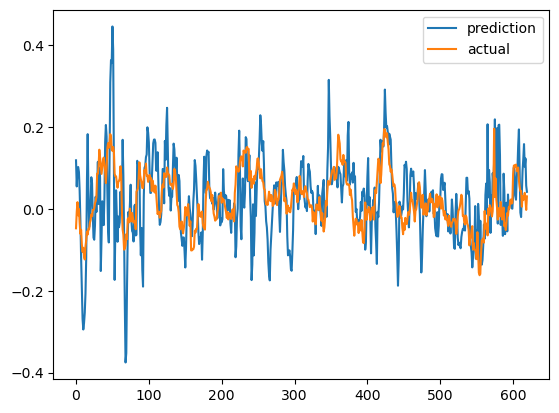

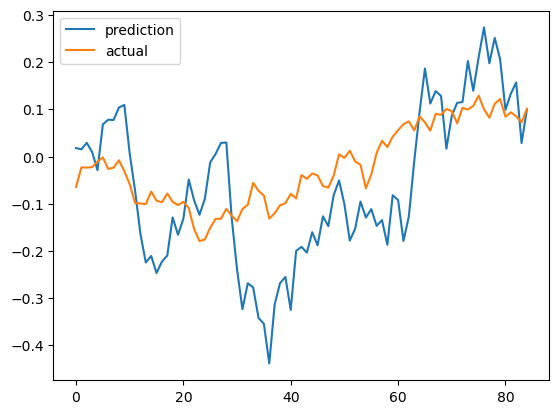

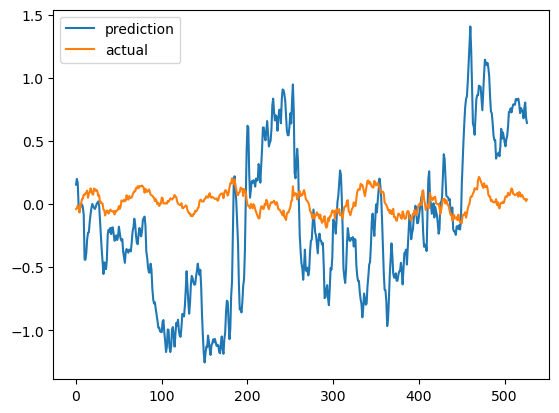

In [ ]:
fig = plt.figure()
plt.plot(range(X_train.shape[0]), model(X_train[:]), label='prediction')
plt.plot(range(X_train.shape[0]), y_train, label='actual')
plt.legend()
fig = plt.figure()
plt.plot(range(X_val.shape[0]), model(X_val[:]), label='prediction')
plt.plot(range(X_val.shape[0]), y_val, label='actual')
plt.legend()
fig = plt.figure()
plt.plot(range(X_test.shape[0]), model(X_test[:]), label='prediction')
plt.plot(range(X_test.shape[0]), y_test, label='actual')
plt.legend()

## Feedback Needed

Currently, the visualization shows that the autoencoder is overfitting. I'm trying to use `L2` regularization to avoid really huge reconstructed 20-day return. I am assuming the problem comes from different time period has a overall trend of 20-day return. Since I split the train-val-test based on `TimeSeriesSplit`, there might be a distribution shift from the training set to test set. I wonder what would be a good idea to solve this other than regularization. In addition, I'm afraid that this weak autoencoder would cause compounding error later on in forecasting.

## Appendix: Data Preparation
We have five raw datasets, each of which comes in different formats. The goal of this section is to prepare the datasets into a unified `DataFrame` with features needed by feature extraction and the same dates. Standardization and pipeline preprocessing would be in the next section.

In [ ]:
import pandas as pd 
import numpy as np 

### AAPL

In [ ]:
aapl = pd.read_csv('../raw_data/AAPL.csv')

# Target the time frame: 2013/05/06 - 2023/04/26
aapl = aapl[(aapl['Date'] >= '2013-05-06') & (aapl['Date'] <= '2023-04-26')]

# Get target features 
aapl_features = aapl[['Date', 'Open', 'Close', 'High', 'Low', 'Volume']]
aapl_features.shape

(2512, 6)

### Macroeconomic Variables

#### US Treasury Bill Bond (13 Weeks)

- Typical Price of US Treasury Bill Bond (13 Weeks)

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

def get_typical_price(X): 
    return np.average(X, axis=1)

risk_free = pd.read_csv('../raw_data/US_Treasury_Bond_13weeks.csv')
risk_free = risk_free.dropna()
risk_free = risk_free[risk_free['Date'] >= '2013-05-06']
transformer = FunctionTransformer(get_typical_price)
typical_price = transformer.fit_transform(risk_free[['High', 'Close', 'Low']])
risk_free = pd.DataFrame({
    'Date': risk_free['Date'], 
    'Typical Price': typical_price
})
risk_free.shape

(2512, 2)

#### S&P 500 Index

In [ ]:
sp500 = pd.read_csv('../raw_data/sp500_index.csv')
sp500 = sp500[sp500['Date'] <= '2023-04-26']
sp500.shape

(2512, 2)

### Fundamentals

#### Valuation measures
- PeRatio: Share price over earnings per share
- PsRatio: Share price over sales per share
- PbRatio: Share price over book per share
- Enterprise value to revenue ratio 
- Enterprise value to EDITDA(Earnings Before Interest, Taxes, Depreciation, and Amortization) ratio

In [ ]:
from datetime import datetime

val_measure = pd.read_csv('../raw_data/AAPL_quarterly_valuation_measures.csv')
# print(val_measure.columns)
peratio = val_measure[val_measure.name == 'PeRatio'].drop(columns=['ttm', 'name'])
psratio = val_measure[val_measure.name == 'PsRatio'].drop(columns=['ttm', 'name'])
pbratio = val_measure[val_measure.name == 'PbRatio'].drop(columns=['ttm', 'name'])
enterprise_val_revenue_ratio = val_measure[val_measure.name == 'EnterprisesValueRevenueRatio'].drop(columns=['ttm', 'name'])
enterprise_val_ebitda_ratio = val_measure[val_measure.name == 'EnterprisesValueEBITDARatio'].drop(columns=['ttm', 'name'])
feats = [peratio, psratio, pbratio, enterprise_val_revenue_ratio, enterprise_val_ebitda_ratio]
names = ['PeRatio', 'PsRatio', 'PbRatio', 'EnterpriseValueRevenueRatio', 'EnterpriseValueEDITDARatio']
dates = sp500.Date 

def quarterly_to_daily(quarter_data, dates, name):
    target_date = []
    for d in dates: 
        target_date.append(np.max(quarter_data.columns[quarter_data.columns <= d]))
    daily_data = np.zeros(dates.shape[0])
    for i, d in enumerate(target_date): 
        daily_data[i] = quarter_data[d]
    return pd.DataFrame({
        'Date': dates,
        name: daily_data
    })

def transform_date_format(X): 
    '''
    Transform the date format of input data's columns to format yyyy-mm-dd

    Args: 
        X: pd.DataFrame where the columns should be quarterly dates in the format mm/dd/yyyy
    Returns: 
        X_transformed: pd.DataFrame where the columns would be quarterly dates in the format yyyy-mm-dd
    '''
    dates = []
    for d in X.columns: 
        date_obj = datetime.strptime(d, '%m/%d/%Y')
        dates.append(date_obj.strftime('%Y-%m-%d'))
    X_transformed = pd.DataFrame(X.values, columns=dates)
    return X_transformed

for i, feat in enumerate(feats): 
    feats[i] = quarterly_to_daily(transform_date_format(feat), dates, names[i])

for i, feat in enumerate(feats): 
    print(feats[i].shape)

(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)
(2512, 2)


#### Financials

- BasicEPS: Earning Per Share

In [ ]:
dates = sp500.Date 
fin_measure = pd.read_csv('../raw_data/AAPL_quarterly_financials.csv')
# print(fin_measure.columns)
eps = fin_measure[fin_measure.name == 'BasicEPS'].drop(columns=['ttm', 'name'])
eps = quarterly_to_daily(transform_date_format(eps), dates, 'BasicEPS')
print(eps.shape)

(2512, 2)


### Concatenate all basic features

In [ ]:
joined_data = pd.merge(aapl_features, sp500, on='Date')
for f in feats: 
    joined_data = pd.merge(joined_data, f, on='Date')
joined_data = pd.merge(joined_data, eps, on='Date')
joined_data.to_csv('../prepared_data/data.csv')